# Implied Volatility Calibration and Risk Management with HJM Model

In this project, the goal is to calibrate an implied volatility surface and use this information to simulate interest rate trajectories using the HJM model. This will allow us to perform risk analyses, such as calculating Value at Risk (VaR), for a portfolio of options or financial assets

## Import libraries

In [30]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

## Download data

In [12]:
#Download data for 10-year Treasury Yield from FRED
df_rate = web.DataReader('GS10', 'fred', start='2000-01-01', end='2025-01-01')

In [13]:
df_rate.head()

GS10
DATE            
2000-01-01  6.66
2000-02-01  6.52
2000-03-01  6.26
2000-04-01  5.99
2000-05-01  6.44

In [35]:
# Here we use the 10-year swap rate as a proxy (check if available in FRED)
swap_rate_data = web.DataReader('DSWP10', 'fred', start='2000-01-01', end='2025-01-01')

In [39]:
swap_rate_data.isna().sum()

DSWP10    179
dtype: int64

## Visualize Fed Funds Rate

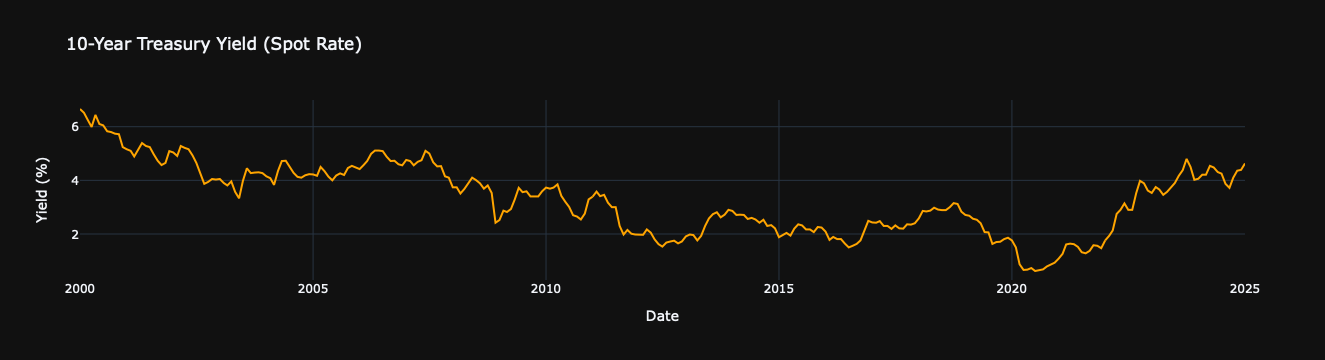

In [25]:
def plot_spot_curve(spot_rate_data):
    """
    Plot the Spot Curve using Plotly.

    Args:
        spot_rate_data (pandas.DataFrame): DataFrame with the 10-year Treasury Yield.
    """
    spot_rate_trace = go.Scatter(
        x=spot_rate_data.index,
        y=spot_rate_data['GS10'],
        mode='lines',
        name='10-Year Treasury Yield (Spot Rate)',
        line=dict(color='orange')
    )

    layout = go.Layout(
        title='10-Year Treasury Yield (Spot Rate)',
        xaxis=dict(title='Date'),
        yaxis=dict(title='Yield (%)'),
        template='plotly_dark'
    )

    fig = go.Figure(data=[spot_rate_trace], layout=layout)
    fig.show()
    
# Plot the Spot Curve
plot_spot_curve(df_rate)

## Forward Rate Formula

The **forward rate** is the interest rate implied by current interest rates for borrowing/lending over a specific future period. It can be calculated using the following formula:

$$
f(t, T) = \frac{(1 + r(T))^T}{(1 + r(t))^t} - 1
$$

Where:

- \( r(t) \) is the spot interest rate at time \( t \).
- \( r(T) \) is the spot interest rate at time \( T \).
- \( f(t, T) \) is the forward rate between time \( t \) and \( T \).

#### Explanation:

- The formula calculates the **forward rate** between two points in time, \( t \) and \( T \), based on the current spot rates \( r(t) \) and \( r(T) \). 
- **Spot rate** is the current interest rate for a given maturity.
- The forward rate is a way to compute the implied interest rate for borrowing or lending money for a future period, based on today's rates.

The formula essentially compares the return of investing from time \( t \) to time \( T \), assuming reinvestment of the spot rate \( r(t) \) and \( r(T) \), and extracts the rate that equates those two returns.


In [27]:
# Define the forward rate formula
def calculate_forward_rate_surface(spot_rate_data):
    """
    Calculate the surface of forward rates for all pairs (t, T).
    
    Args:
        spot_rate_data (pandas.DataFrame): DataFrame with spot rates.
    
    Returns:
        pandas.DataFrame: DataFrame containing the forward rate matrix.
    """
    # Initialize an empty matrix to store forward rates
    forward_rate_surface = pd.DataFrame(index=spot_rate_data.index, columns=spot_rate_data.index)
    
    # Convert spot rates from percentage to decimal
    spot_rate_data = spot_rate_data / 100
    
    # Loop over all pairs (t, T)
    for i in range(len(spot_rate_data)):
        for j in range(i+1, len(spot_rate_data)):  # Only compute upper triangular part
            t = spot_rate_data.index[i]
            T = spot_rate_data.index[j]
            
            r_t = spot_rate_data.iloc[i, 0]
            r_T = spot_rate_data.iloc[j, 0]
            
            # Calculate forward rate f(t, T)
            f_t_T = ((1 + r_T) ** (T.year - t.year) / (1 + r_t) ** (t.year - t.year)) - 1
            
            # Store the forward rate in both [t, T] and [T, t] positions for symmetry
            forward_rate_surface.iloc[i, j] = f_t_T
            forward_rate_surface.iloc[j, i] = f_t_T

    return forward_rate_surface

# Calculate the forward rate surface
forward_rate_surface = calculate_forward_rate_surface(df_rate)

# Display the first few rows of the forward rate surface
forward_rate_surface.head()

DATE       2000-01-01 2000-02-01 2000-03-01 2000-04-01 2000-05-01 2000-06-01  \
DATE                                                                           
2000-01-01        NaN        0.0        0.0        0.0        0.0        0.0   
2000-02-01        0.0        NaN        0.0        0.0        0.0        0.0   
2000-03-01        0.0        0.0        NaN        0.0        0.0        0.0   
2000-04-01        0.0        0.0        0.0        NaN        0.0        0.0   
2000-05-01        0.0        0.0        0.0        0.0        NaN        0.0   

DATE       2000-07-01 2000-08-01 2000-09-01 2000-10-01  ... 2024-04-01  \
DATE                                                    ...              
2000-01-01        0.0        0.0        0.0        0.0  ...   1.902551   
2000-02-01        0.0        0.0        0.0        0.0  ...   1.902551   
2000-03-01        0.0        0.0        0.0        0.0  ...   1.902551   
2000-04-01        0.0        0.0        0.0        0.0  ...   1.902551   
2000-05-01        0.0        0.0        0.0        0.0  ...   1.902551   

DATE       2024-05-01 2024-06-01 2024-07-01 2024-08-01 2024-09-01 2024-10-01  \
DATE                                                                           
2000-01-01   1.862832   1.753104   1.715348     1.4875   1.402704   1.623116   
2000-02-01   1.862832   1.753104   1.715348     1.4875   1.402704   1.623116   
2000-03-01   1.862832   1.753104   1.715348     1.4875   1.402704   1.623116   
2000-04-01   1.862832   1.753104   1.715348     1.4875   1.402704   1.623116   
2000-05-01   1.862832   1.753104   1.715348     1.4875   1.402704   1.623116   

DATE       2024-11-01 2024-12-01 2025-01-01  
DATE                                         
2000-01-01   1.784952   1.804229   2.100314  
2000-02-01   1.784952   1.804229   2.100314  
2000-03-01   1.784952   1.804229   2.100314  
2000-04-01   1.784952   1.804229   2.100314  
2000-05-01   1.784952   1.804229   2.100314  

[5 rows x 301 columns]

## Visualize Forward rates

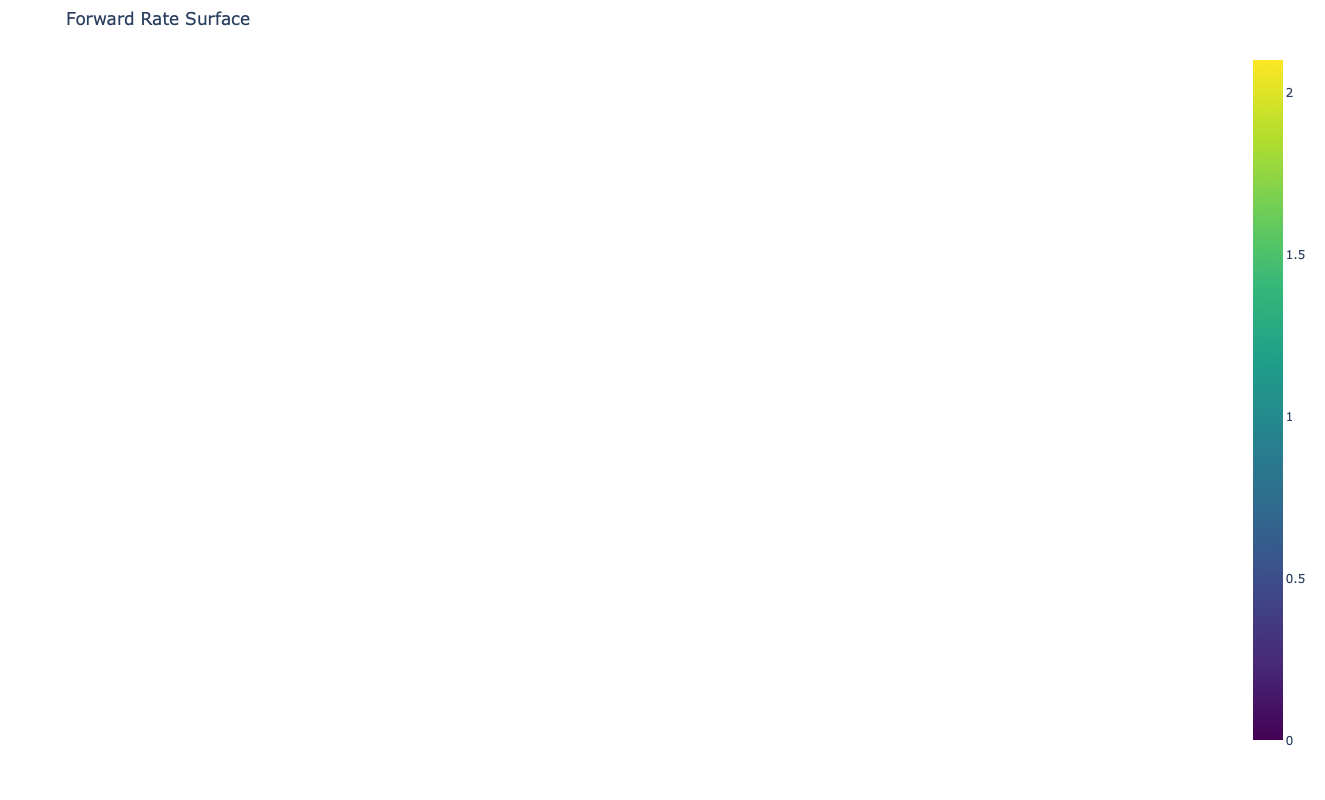

In [32]:
def plot_forward_rate_surface(forward_rate_surface):
    """
    Plot the surface of forward rates using Plotly with improved layout for better visualization.
    
    Args:
        forward_rate_surface (pandas.DataFrame): DataFrame containing the forward rate matrix.
    """
    # Extract the data for the plot
    x = forward_rate_surface.columns
    y = forward_rate_surface.index
    z = forward_rate_surface.values

    # Create the surface plot using plotly.graph_objects
    fig = go.Figure(data=[go.Surface(z=z, x=x, y=y, colorscale='Viridis')])

    # Update the layout for better visualization
    fig.update_layout(
        title='Forward Rate Surface',
        scene=dict(
            xaxis_title='Maturity (Years)',
            yaxis_title='Maturity (Years)',
            zaxis_title='Forward Rate (%)',
            xaxis=dict(showgrid=True, gridwidth=2, ticklen=5, titlefont=dict(size=16)),
            yaxis=dict(showgrid=True, gridwidth=2, ticklen=5, titlefont=dict(size=16)),
            zaxis=dict(showgrid=True, gridwidth=2, ticklen=5, titlefont=dict(size=16)),
        ),
        coloraxis_colorbar=dict(title='Forward Rate (%)'),
        width=1000,  # Increase width of the figure
        height=800,  # Increase height of the figure
        margin=dict(l=50, r=50, b=50, t=50)  # Set margins to avoid clipping
    )

    # Show the plot
    fig.show()

# Plot the forward rate surface
plot_forward_rate_surface(forward_rate_surface)

## Modeling Interest Rate Dynamics: Vasicek vs. Jump-Diffusion Models

In this section, we explore two popular approaches to model the evolution of interest rates: the **Vasicek model** and a **Jump-Diffusion model**. We aim to compare their theoretical foundations and use them to understand how they can impact curve calibration or imputing missing values.

### Vasicek Model

The **Vasicek model** is a one-factor short-rate model defined by the following stochastic differential equation (SDE):

$$
dr_t = a(b - r_t)dt + \sigma dW_t
$$

- $r_t$: short-term interest rate at time $ t $
- $ a$: speed of mean reversion
- $b$: long-term mean level
- $\sigma$: volatility
- $dW_t$: standard Brownian motion (Wiener process)

#### 📌 Key Properties:
- **Mean-reverting**: The rate tends to return to its long-term mean $b$.
- **Normally distributed**: $r_t$ can be negative.
- **Analytically tractable**: Bond prices and forward rates have closed-form solutions.


In [40]:
def simulate_vasicek(r0, a, b, sigma, T, dt, n_paths):
    """
    Simulates interest rate paths using the Vasicek model.

    Parameters:
        r0 (float): Initial interest rate
        a (float): Speed of mean reversion
        b (float): Long-term mean level
        sigma (float): Volatility
        T (float): Total time in years
        dt (float): Time step
        n_paths (int): Number of simulation paths

    Returns:
        np.ndarray: Simulated interest rate paths (n_paths x time_steps)
    """
    n_steps = int(T / dt)
    rates = np.zeros((n_paths, n_steps))
    rates[:, 0] = r0

    for t in range(1, n_steps):
        dr = a * (b - rates[:, t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal(size=n_paths)
        rates[:, t] = rates[:, t-1] + dr

    return rates

### Jump-Diffusion Model

To incorporate sudden, discontinuous changes in interest rates (e.g., during policy announcements or financial crises), we introduce a **Jump-Diffusion model**:

$$
dr_t = a(b - r_t)dt + \sigma dW_t + J_t dN_t
$$

- $J_t $: random jump size, often modeled as a normal or exponential variable
- $N_t $: Poisson process with intensity $ \lambda $(expected number of jumps per unit time)

#### 📌 Key Properties:
- **Captures extreme events**: Discontinuous movements are explicitly modeled.
- **Non-Gaussian distribution**: Fat tails and skewness possible.
- **Useful for risk scenarios**: Especially in stress-testing and pricing derivatives with jump sensitivity.

In [42]:
def simulate_jump_diffusion(r0, a, b, sigma, T, dt, n_paths, lam, mu_j, sigma_j):
    """
    Simulates interest rate paths using a jump-diffusion model.

    Parameters:
        r0 (float): Initial rate
        a, b, sigma (float): Vasicek model parameters
        T (float): Total time in years
        dt (float): Time step
        n_paths (int): Number of simulation paths
        lam (float): Intensity of jumps (Poisson rate)
        mu_j (float): Mean of jump size
        sigma_j (float): Std dev of jump size

    Returns:
        np.ndarray: Simulated paths with jumps
    """
    n_steps = int(T / dt)
    rates = np.zeros((n_paths, n_steps))
    rates[:, 0] = r0

    for t in range(1, n_steps):
        # Diffusion part (like Vasicek)
        dr = a * (b - rates[:, t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal(size=n_paths)

        # Jump component
        jumps = np.random.poisson(lam * dt, size=n_paths) * np.random.normal(mu_j, sigma_j, size=n_paths)

        # Total update
        rates[:, t] = rates[:, t-1] + dr + jumps

    return rates

### Comparison

| Feature                  | Vasicek Model         | Jump-Diffusion Model       |
|--------------------------|-----------------------|----------------------------|
| Mean-reversion           | Yes                   | Yes                        |
| Gaussian distribution    | Yes                   | No (heavy tails possible)  |
| Handles extreme events   | No                    | Yes                        |
| Tractability             | High                  | Moderate (requires numerical methods) |
| Calibration complexity   | Low                   | Higher (additional parameters) |

### Why This Matters

In real-world interest rate data (like swap or LIBOR rates), we often observe sudden changes that are **not well explained** by purely diffusive models. Using Jump-Diffusion allows us to capture this behavior, improving:

- **Curve fitting and calibration**.
- **Scenario generation for risk management**.
- **Imputation of missing values** in a time series with irregular behavior.

In the next section, we will simulate both models and visually compare their behaviors.

In [41]:
def plot_simulation(rates, title):
    """
    Plots simulation paths using Plotly.

    Parameters:
        rates (np.ndarray): Simulated rate paths
        title (str): Plot title
    """
    fig = go.Figure()

    for i in range(min(10, rates.shape[0])):
        fig.add_trace(go.Scatter(
            y=rates[i],
            mode='lines',
            name=f'Path {i+1}',
            line=dict(width=1)
        ))

    fig.update_layout(
        title=title,
        xaxis_title="Time Step",
        yaxis_title="Interest Rate",
        width=900,
        height=500
    )
    fig.show()

### Swap Rate and Newton-Raphson Method for Forward Rate Calibration

#### What is a Swap Rate?

A $\textbf{swap rate}$ is the fixed interest rate that one party agrees to pay in exchange for receiving a floating rate in a financial contract known as an $\textit{interest rate swap}$. Typically, the floating rate is tied to an underlying benchmark such as LIBOR or SOFR.

The swap rate reflects the price at which two parties agree to exchange the fixed and floating cash flows over a certain maturity. In the context of calibrating forward rates, we can use observed swap rates for various maturities to infer the expectations of future interest rates in the market.

$
\text{Fixed Rate} = \text{Swap Rate}
$

#### Forward Rates and Swap Rates

A $\textbf{forward rate}$ represents the interest rate agreed upon today for a loan that will be made in the future, starting at some future time \( t \) and ending at $time \( t + \tau \$). Forward rates can be derived from spot rates (current interest rates for a given period) using the following relationship:

$$
1 + f(t, t+\tau) = \frac{(1 + r(t+\tau))^{t+\tau}}{(1 + r(t))^{t}}
$$

Where:
- $ f(t, t+\tau)$ is the forward rate between time $ t $ and $t+\tau$.
- $r(t)$ is the spot rate at time $t$.
- $t$ is the current time and $\tau$ is the time to maturity.

#### What is the Newton-Raphson Method?

The $\textbf{Newton-Raphson method}$ is an iterative numerical technique used to find the roots (or solutions) of a real-valued function. In the context of calibrating financial models, it can be used to adjust the parameters of a model, such that the model's output matches the observed data.

The method works as follows:
1. Choose an initial guess $ x_0$for the solution.
2. Compute the function value $f(x_0)$ and its derivative $f'(x_0)$.
3. Update the guess using the following formula:

$$ x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$$


4. Repeat steps 2 and 3 until the solution converges (i.e., $f(x_n)$ becomes sufficiently close to zero).

In our case, the goal is to minimize the difference between the forward rates implied by our model and the observed swap rates using the Newton-Raphson method. This allows us to calibrate the curve of forward rates by adjusting the model's parameters.

#### Steps for Calibration of Forward Rates using Swap Rates

To calibrate the forward rates using the swap rates, we will follow these steps:
1. **Gather Swap Rates**: Collect the swap rates for various maturities.
2. **Define a Model for Forward Rates**: Choose a parametric model (such as the Nelson-Siegel model) for the forward rates.
3. **Define the Objective Function**: The objective function will be the sum of squared differences between the forward rates calculated from the model and the observed swap rates.
4. **Apply Newton-Raphson**: Use the Newton-Raphson method to minimize the objective function and calibrate the model to match the observed swap rates.

#### Objective Function and Calibration Process

The objective function is given by:

$$
\text{Objective Function} = \sum_{i=1}^{n} \left( \text{Forward Rate}_{\text{model}}(t_i) - \text{Swap Rate}_{\text{observed}}(t_i) \right)^2
$$

Where:
- $\text{Forward Rate}_{\text{model}}(t_i)$ is the forward rate derived from the model for time $t_i$.
- $\text{Swap Rate}_{\text{observed}}(t_i)$ is the observed swap rate for time $t_i$.

We will apply the Newton-Raphson method to adjust the parameters of the model so that the forward rates predicted by the model match as closely as possible to the swap rates observed in the market.